In [ ]:
# mouse targets
# index   identifier      file    description
# 0       Hsieh2019_mESC_uC       /home/drk/hic/data/data/coolers/mm10/Hsieh2019/mESC_mm10_4DNFILZ1CPT8.mapq_30.2048.cool HIC:mESC
# 1       Bonev2017_mESC  /home/drk/hic/data/data/coolers/mm10/Bonev2017/HiC_ES_all.mm10.mapq_30.2048.cool        HIC:mESC
# 2       Bonev2017_CN    /home/drk/hic/data/data/coolers/mm10/Bonev2017/HiC_CN_all.mm10.mapq_30.2048.cool        HIC:cortical neuron
# 3       Bonev2017_ncx_CN        /home/drk/hic/data/data/coolers/mm10/Bonev2017/HiC_ncx_CN_all.mm10.mapq_30.2048.cool    HIC:neocortex cortical neuron
# 4       Bonev2017_NPC   /home/drk/hic/data/data/coolers/mm10/Bonev2017/HiC_NPC_all.mm10.mapq_30.2048.cool       HIC:neural progenitor cell
# 5       Bonev2017_ncx_NPC       /home/drk/hic/data/data/coolers/mm10/Bonev2017/HiC_ncx_NPC_all.mm10.mapq_30.2048.cool   HIC:neocortex neural progenitor cell

In [1]:
cool_paths = {"Hsieh2019_mESC_uC_path" : "/project/fudenber_735/GEO/Hsieh2019/4DN/mESC_mm10_4DNFILZ1CPT8.mapq_30.2048.cool",
"Bonev2017_mESC_path" : "/project/fudenber_735/GEO/bonev_2017_GSE96107/distiller-0.3.1_mm10/results/coolers/HiC_ES_all.mm10.mapq_30.2048.cool",
"Bonev2017_CN_path" : "/project/fudenber_735/GEO/bonev_2017_GSE96107/distiller-0.3.1_mm10/results/coolers/HiC_CN_all.mm10.mapq_30.2048.cool",
"Bonev2017_ncx_CN_path" : "/project/fudenber_735/GEO/bonev_2017_GSE96107/distiller-0.3.1_mm10/results/coolers/HiC_ncx_CN_all.mm10.mapq_30.2048.cool",
"Bonev2017_NPC_path" : "/project/fudenber_735/GEO/bonev_2017_GSE96107/distiller-0.3.1_mm10/results/coolers/HiC_NPC_all_mm10.mapq_30.1024.cool",
"Bonev2017_ncx_NPC_path" : "/project/fudenber_735/GEO/bonev_2017_GSE96107/distiller-0.3.1_mm10/results/coolers/HiC_ncx_NPC_all.mm10.mapq_30.2048.cool"}

In [2]:
import warnings
warnings.filterwarnings("ignore") 

import numpy as np
import pandas as pd
import cooler
from cooltools.lib.numutils import observed_over_expected, adaptive_coarsegrain
from cooltools.lib.numutils import interpolate_bad_singletons, set_diag, interp_nan
from astropy.convolution import Gaussian2DKernel
from astropy.convolution import convolve
from bioframe.io.fileops import read_bigwig

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
def get_target(cooler_path, padding, mseq_str, diagonal_offset=2):
    
    genome_hic_cool = cooler.Cooler(cooler_path)
    
    seq_hic_raw = genome_hic_cool.matrix(balance=True).fetch(mseq_str)

    seq_hic_nan = np.isnan(seq_hic_raw)
    # num_filtered_bins = np.sum(np.sum(seq_hic_nan,axis=0) == len(seq_hic_nan))

    # clip first diagonals and high values
    clipval = np.nanmedian(np.diag(seq_hic_raw, diagonal_offset))
    for i in range(-diagonal_offset+1, diagonal_offset):
        set_diag(seq_hic_raw, clipval, i)
    seq_hic_raw = np.clip(seq_hic_raw, 0, clipval)
    seq_hic_raw[seq_hic_nan] = np.nan
    
    # adaptively coarsegrain based on raw counts
    seq_hic_smoothed = adaptive_coarsegrain(
                        seq_hic_raw,
                        genome_hic_cool.matrix(balance=False).fetch(mseq_str),
                        cutoff=2, max_levels=8)
    seq_hic_nan = np.isnan(seq_hic_smoothed)
    
    # local obs/exp
    seq_hic_obsexp = observed_over_expected(seq_hic_smoothed, ~seq_hic_nan)[0]
    log_hic_obsexp = np.log(seq_hic_obsexp)

    # crop
    if padding > 0:
        log_hic_obsexp = log_hic_obsexp[padding:-padding,:]
        log_hic_obsexp = log_hic_obsexp[:,padding:-padding]

    # aplying Gaussian Kernel
    kernel = Gaussian2DKernel(x_stddev=1)
    kernel_log_hic_obsexp = convolve(log_hic_obsexp, kernel)
    
    return kernel_log_hic_obsexp

In [40]:
seq_len_nt = 1310720
padding = (640-512) // 2

# chrom = "chr3"
# start = 53348564
# end = 53348564 + seq_len_nt

# chrom = "chr14"
# gene_start = 58083863
# gene_end = 58089096

# chrom = "chr2"
# gene_start = 79452639
# gene_end = 79456636

# chrom = "chr4"
# gene_start = 10881264
# gene_end = 10906709

# chrom = "chr1"
# gene_start = 66321719
# gene_end = 66439188

# chrom = "chr1"
# start = 57299397
# end = 57299397 + seq_len_nt

# chrom = "chr7"
# start = 71039589
# end = 71039589 + seq_len_nt

chrom = "chr9"
gene_start = 63163768
gene_end = 63377902

gene_length = gene_end - gene_start

if gene_length % 2 == 1:
    gene_start = gene_start - 1

if gene_length < seq_len_nt:
    difference = (seq_len_nt - (gene_end - gene_start))
    start = gene_start - (difference // 2)
else:
    start = gene_start
    
end = start + seq_len_nt

In [41]:
mseq_str = '%s:%d-%d' % (chrom, start, end)

In [42]:
mseq_str

'chr9:62615475-63926195'

In [43]:
targets = []

for path in cool_paths:
    targets.append(get_target(cool_paths[path], padding, mseq_str))

In [44]:
def plot_maps_with_labels(maps, labels, vmin=-0.6, vmax=0.6, palette="RdBu_r", width=20, height=5):
    fig, axes = plt.subplots(1, len(maps), figsize=(width, height))

    for i, (matrix, label) in enumerate(zip(maps, labels)):
        sns.heatmap(
            matrix,
            vmin=vmin,
            vmax=vmax,
            cbar=False,
            cmap=palette,
            square=True,
            xticklabels=False,
            yticklabels=False,
            ax=axes[i]
        )
        axes[i].set_title(label, fontsize=12)  # Set the label above the heatmap

    plt.tight_layout()
    plt.show()

In [45]:
labels = ["mESC", "mESC", "cortical neuron", "neocortex cortical neuron", "neural progenitor cell", "neocortex neural progenitor cell"]

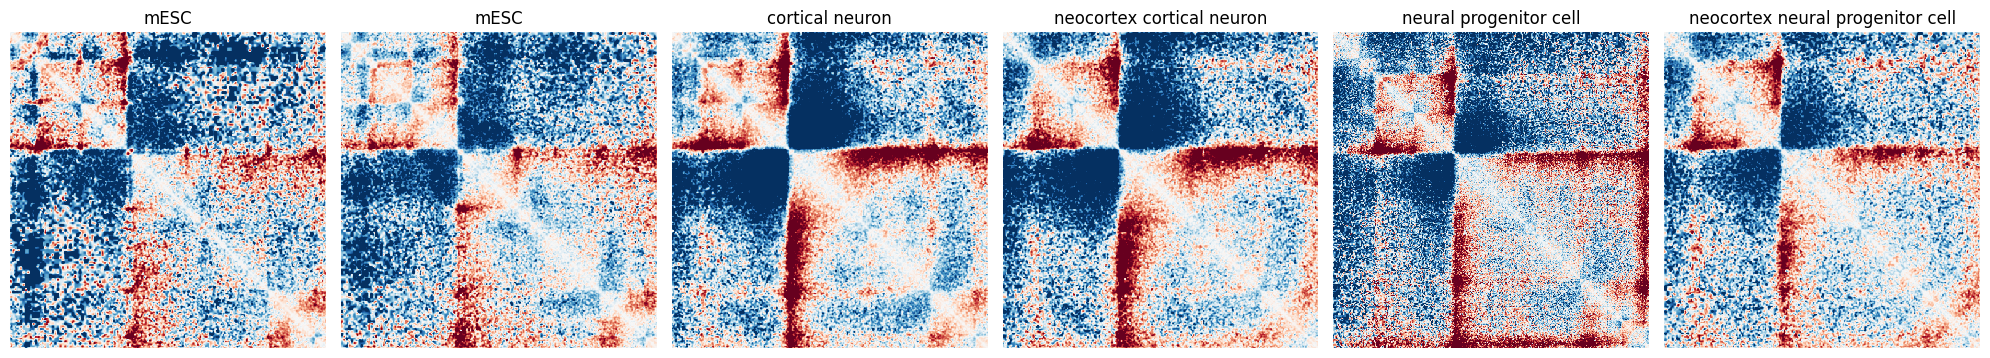

In [46]:
plot_maps_with_labels(targets, labels)